## Introduction ##

This Jupyter notebook is designed to simulate the dynamics of the activated random walk on the interval and on the comb. We sample the stationary distribution by first stabalizing the configuration with one active particle per site, and then using central driving with one particle to sample again. We choose to represent the comb and interval as arrays, with each site corresponding to an entry of the array. Entries of -1 to represent sleeping particles at the corresponding site, and other natural numbers record the number of particles at a given site.    

In [1]:
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import cProfile

In [75]:
#Helper method for choosing 1 of 3 options. This is called a lot so we want it to be fast. 
def rand3():
    #Find a random integer from 0,1,2. Supposedly fast?
    while True:
        r = random.getrandbits(2)
        if r < 3:
            return r

## The Interval ##

In [76]:
#Function for adding a particle to the interval. Returns true only if the particle fell into a sink. 
def add_particle_to_interval(interval, index_col):
    length = interval.shape[0]
    #If the index we want to move to is outside the length of the interval, we moved into a sink, so do nothing
    if index_col >= length or index_col< 0:
        #If the particle fell off, we want to find a new active particle
        return True
    #If the site we moved into has a sleeping particle, wake it up so we have 2 active particles in it. 
    elif interval[index_col] == -1:
        interval[index_col] = 2
        #We can keep tracking this active particle.
        return False
    #Otherwise we have one more active particle. 
    else:
        interval[index_col] += 1
        #We can keep tracking this active particle.
        return False

In [77]:
#Function for stabalizing the interval, returns nothing but changes the interval array passed as an argument
def stabalize_interval(interval, sleep_rate):
    #We begin by searching for the index of an active particle
    searching_for_index = True
    #Loop while there are still active particles in the interval
    while(True):
        #If we are not already tracking an active particle, look for a new one
        if searching_for_index:
            #Find the index of the first site with at least one active particle. If no such index exists we are stable, and so exit. 
            positive_indices = np.flatnonzero(interval > 0)
            if positive_indices.size > 0:
                active_index = positive_indices[0]
                #Found a new active particle to track
                searching_for_index = False
            else:
                return interval

        #If only one particle is in the active site, it can fall asleep 
        if interval[active_index] == 1:
            #r is drawn uniformly from (0,1)
            r = random.random()
            #If r is small enough (< lambda/(1+lambda)) the particle falls alseep
            if r < sleep_rate/(1+sleep_rate):
                #Particle is asleep, so the value at the site is -1
                interval[active_index] = -1
                #Particle fell asleep, so need to find new active particle to track
                searching_for_index = True
            else:
                #If our only active particle moved, we set the entry in the site to 0
                interval[active_index] = 0
                #Pick a random direction
                if bool(random.getrandbits(1)):
                    #Moved to the right, so increment the index by 1
                    active_index += 1
                    searching_for_index = add_particle_to_interval(interval, active_index)
                else:
                    #Moved to the left, so decrement the index by 1
                    active_index -= 1
                    searching_for_index = add_particle_to_interval(interval, active_index)
        #If multiple active particles, one must move
        else:  
            #Particle moved so reduce the number by 1
            interval[active_index] -= 1
            #Move right
            if bool(random.getrandbits(1)):
                active_index += 1
                searching_for_index = add_particle_to_interval(interval, active_index)
            #Move left
            else:
                active_index -= 1
                searching_for_index = add_particle_to_interval(interval, active_index)

In [78]:
def run_simulation_interval(interval_length, sleep_rate, num_trials):
    #Start with an estimate of 0 for the density. 
    interval_density = 0
    #The interval begins with active particles at each site
    interval = np.ones(interval_length)
    #Progress bar so we know about how long things will take
    for _ in tqdm(range(num_trials), desc=f"Running trials (L={interval_length}, r={sleep_rate})", leave=False):
        stabalize_interval(interval, sleep_rate)
        #The density is the number of sleeping particles divided by the length, sleeping particles are represented by -1
        #-= as we are summing -1 for each sleeping particle left
        interval_density -= np.sum(interval)/interval_length
        #Add an active particle in the center. 
        add_particle_to_interval(interval, int(interval_length/2))
    #Return the average density over the trials
    return interval_density/num_trials

In [79]:
def generate_data_interval(interval_lengths, sleep_rates, num_trials_each):
    data = np.zeros((len(interval_lengths), len(sleep_rates)))
    #Loop over parameters and run simulations
    for i, length in enumerate(interval_lengths):
        for j, sleep_rate in enumerate(sleep_rates):
            data[i, j] = run_simulation_interval(length, sleep_rate, num_trials_each)
    return data

## The Comb ##

In [80]:
#Function for adding particle to the comb. Returns true only if the particle fell into a sink 
def add_particle_to_comb(comb, index_row, index_col):
    length = comb.shape[1]
    #If the index we want to move to is outside the length of the comb, we moved into a sink, so do nothing
    if index_col >= length or index_col< 0:
        #If the particle fell off, we want to find a new active particle
        return True
    #If the site we moved into has a sleeping particle, wake it up so we have 2 active particles in it. 
    elif comb[index_row, index_col] == -1:
        comb[index_row, index_col] = 2
        #We can keep tracking this active particle.
        return False
    #Otherwise we have one more active particle. 
    else:
        comb[index_row, index_col] += 1
        #We can keep tracking this active particle.
        return False

In [81]:
def sample_stationary_distribution_comb(comb, sleep_rate):
    #Start out searching for an active particle
    searching_for_index = True
    while(True):
        #This is expensive, so don't want to run it unless we have to
        if searching_for_index:
            #Find the index of the first site with at least one active particle. If no such index exists we are stable, and so exit. 
            positive_indices = np.flatnonzero(comb > 0)
            if positive_indices.size > 0:
                active_index = np.unravel_index(positive_indices[0], comb.shape)
                #Once we find an active particle, want to keep tracking it until it falls off or falls asleep
                searching_for_index = False
            else:
                return comb
        #If only one particle is in the active site, it can fall asleep 
        if comb[active_index] == 1:
            r = random.random()
            #Entry of -1 means sleeping particle
            if r < sleep_rate/(1+sleep_rate):
                comb[active_index] = -1
                #If a particle falls alseep, we want to find a new active particle to track
                searching_for_index = True
            else:
                #If our only active particle moved, we set the entry in the site to 0
                comb[active_index] = 0
                #If we are in the tooth, the only place to go is down
                if active_index[0] == 0:
                    active_index = (active_index[0] + 1, active_index[1])
                    searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])
                else:
                    #Otherwise pick a random direction to move in
                    direction = rand3()
                    #Move up
                    if direction == 0:
                        active_index = (active_index[0] - 1, active_index[1])
                        searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])
                    #Move right
                    elif direction == 1:
                        active_index = (active_index[0], active_index[1] + 1)
                        searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])
                    #Move left
                    elif direction == 2:
                        active_index = (active_index[0], active_index[1] - 1)
                        searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])
        #If multiple active particles, one must move
        else:  
            #Particle moved so reduce the number by 1
            comb[active_index] -= 1
            #If in the tooth must move down. 
            if active_index[0] == 0:
                    active_index = (active_index[0] + 1, active_index[1])
                    searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])
            else:
                #Pick a random direction to move
                direction = rand3()
                if direction == 0:
                    active_index = (active_index[0] - 1, active_index[1])
                    searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])
                elif direction == 1:
                    active_index = (active_index[0], active_index[1] + 1)
                    searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])
                elif direction == 2:
                    active_index = (active_index[0], active_index[1] - 1)
                    searching_for_index = add_particle_to_comb(comb, active_index[0], active_index[1])

In [82]:
def run_simulation_comb(comb_length, sleep_rate, num_trials):
    #Record these densities seperately
    tooth_density = 0
    spine_density = 0
    comb = np.ones((2, comb_length))
    for _ in tqdm(range(num_trials), desc=f"Running trials (L={comb_length}, r={sleep_rate})", leave=False):
        sample_stationary_distribution_comb(comb, sleep_rate)
        #Minus as we are summing -1 for each sleeping particle left
        tooth_density -= np.sum(comb[0])/comb_length
        spine_density -= np.sum(comb[1])/comb_length
        #Add a particle in row 1 (the spine) in the center. 
        add_particle_to_comb(comb, 1, int(comb_length/2))
    return [tooth_density / num_trials, spine_density/num_trials]

In [83]:
def generate_data_comb(comb_lengths, sleep_rates, num_trials_each):
    data = np.zeros((len(comb_lengths), len(sleep_rates), 2))
    for i, length in enumerate(comb_lengths):
        for j, sleep_rate in enumerate(sleep_rates):
            data[i, j, :] = run_simulation_comb(length, sleep_rate, num_trials_each)
    return data

## Running Trials ## 

In [71]:
comb_lengths = [250]
sleep_rates = np.arange(0.1, 1.5, 0.1)
num_trials = 1000
comb_data = generate_data_comb(comb_lengths, sleep_rates, num_trials)
interval_data = generate_data_interval(comb_lengths, sleep_rates, num_trials)

## Plotting ## 

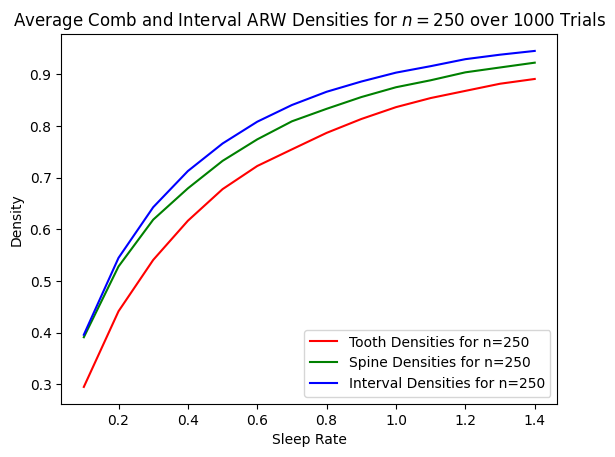

In [73]:
plt.plot(sleep_rates, comb_data[0, :, 0], color='r', label='Tooth Densities for n=250')
plt.plot(sleep_rates, comb_data[0, :, 1], color='g', label='Spine Densities for n=250')
plt.plot(sleep_rates, interval_data[0, :], color='b', label='Interval Densities for n=250')

plt.xlabel("Sleep Rate")
plt.ylabel("Density")
plt.title("Average Comb and Interval ARW Densities for $n=250$ over 1000 Trials")

plt.legend()

plt.show()
plt.close()